# Data Load

In [10]:
# 라이브러리 임포트 및 GPU 설정
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot
from numpy.linalg import norm
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
import os

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor

# value_round 함수 제거
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor: normalization(tensor, 0, 1))
])

# MNIST 데이터셋 로드
train_dataset = datasets.MNIST(root='./MNIST_dataset', train=True, transform=img_transform, download=True)
test_dataset = datasets.MNIST(root='./MNIST_dataset', train=False, transform=img_transform, download=True)

# 데이터로더 정의
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


# Models

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(Autoencoder, self).__init__()
        # 인코더
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, latent_dim)
        )
        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )
        
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # 인코더
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 2*latent_dim)
        )
        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = h[:, :self.latent_dim]
        logvar = h[:, self.latent_dim:]
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

# Training Functions

In [12]:
def train_ae(model, dataloader, epochs=20, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, _ in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        if epoch % 10 == 0 or (epoch + 1) == epochs:
            print(f"AE Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

def train_vae(model, dataloader, epochs=20, lr=1e-3, beta=1.0):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_recon = 0.0
        total_kl = 0.0
        for data, _ in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            
            # 모델 순전파
            recon, mu, logvar = model(data)
            
            # 재구성 손실 (Mean Squared Error)
            recon_loss = nn.functional.mse_loss(recon, data, reduction='sum')
            
            # KL 발산 계산
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            # KL 발산 정규화: 배치 크기와 잠재 변수 차원 수로 나눔
            # batch_size = data.size(0)
            # kl_loss_normalized = kl_loss / (batch_size * 28*28)
            kl_loss_normalized = kl_loss
            
            # 총 손실: 재구성 손실 + beta * 정규화된 KL 발산
            loss = recon_loss + beta * kl_loss_normalized
            loss.backward()
            optimizer.step()
            
            # 손실 누적
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss_normalized.item()
        
        # 에포크당 평균 손실 계산
        avg_loss = total_loss / len(dataloader.dataset)
        avg_recon = total_recon / len(dataloader.dataset)
        avg_kl = total_kl / len(dataloader.dataset)
        
        # 로그 출력: 10 에포크마다 또는 마지막 에포크에서 출력
        if epoch % 10 == 0 or (epoch + 1) == epochs:
            print(f"VAE Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")

# Training

In [13]:
# 잠재 공간 차원, epoch 수, learning rate 설정
latent_dim = 20
epochs = 50
lr = 3e-4
beta = 1.0

# AE 모델 초기화 및 학습
ae_model = Autoencoder(latent_dim=latent_dim)
print("Training Autoencoder...")
train_ae(ae_model, train_loader, epochs=epochs, lr=lr)

# VAE 모델 초기화 및 학습
vae_model = VAE(latent_dim=latent_dim)
print("\nTraining Variational Autoencoder...")
train_vae(vae_model, train_loader, epochs=epochs, lr=lr, beta=beta)

Training Autoencoder...
AE Epoch [1/50], Loss: 0.1181
AE Epoch [11/50], Loss: 0.0188
AE Epoch [21/50], Loss: 0.0141
AE Epoch [31/50], Loss: 0.0124
AE Epoch [41/50], Loss: 0.0114
AE Epoch [50/50], Loss: 0.0107

Training Variational Autoencoder...
VAE Epoch [1/50], Loss: 100.7217, Recon: 94.4233, KL: 6.2983
VAE Epoch [11/50], Loss: 37.8822, Recon: 28.7871, KL: 9.0951
VAE Epoch [21/50], Loss: 34.3215, Recon: 23.6034, KL: 10.7181
VAE Epoch [31/50], Loss: 32.8848, Recon: 21.5527, KL: 11.3321
VAE Epoch [41/50], Loss: 32.0151, Recon: 20.3523, KL: 11.6628
VAE Epoch [50/50], Loss: 31.5284, Recon: 19.6355, KL: 11.8929


# Interpolation Test

In [14]:
# 테스트 데이터에서 두 개의 샘플 선택 (예: 클래스 1과 7)
def get_samples(dataset, class1, class2):
    sample1 = None
    sample2 = None
    for data, label in dataset:
        if label == class1 and sample1 is None:
            sample1 = data
        elif label == class2 and sample2 is None:
            sample2 = data
        if sample1 is not None and sample2 is not None:
            break
    if sample1 is None or sample2 is None:
        raise ValueError(f"Couldn't find samples for classes {class1} and {class2}")
    return sample1.unsqueeze(0), sample2.unsqueeze(0)

In [32]:
# SLERP 함수 정의
def slerp(val, low, high):
    """
    Spherical linear interpolation between two vectors.
    
    Args:
        val (float): interpolation factor between 0 and 1
        low (np.array): starting vector
        high (np.array): ending vector
        
    Returns:
        np.array: interpolated vector
    """
    omega = np.arccos(np.clip(dot(low / norm(low), high / norm(high)), -1.0, 1.0))
    if omega == 0:
        return low
    return (np.sin((1.0 - val) * omega) / np.sin(omega)) * low + (np.sin(val * omega) / np.sin(omega)) * high

def interpolate_slerp(z1, z2, steps=5):
    """
    Perform SLERP between two vectors z1 and z2.
    
    Args:
        z1 (np.array): starting vector
        z2 (np.array): ending vector
        steps (int): number of interpolation steps
        
    Returns:
        np.array: array of interpolated vectors, shape [steps, latent_dim]
    """
    ratios = np.linspace(0, 1, steps)
    interpolated = np.array([slerp(r, z1, z2) for r in ratios])
    return interpolated

# PSNR 계산 함수 정의
def calculate_psnr(original, reconstructed):
    """
    Calculate PSNR between two images.
    
    Args:
        original (np.array): original image, shape [28, 28], values between 0 and 1
        reconstructed (np.array): reconstructed image, shape [28, 28], values between 0 and 1
        
    Returns:
        float: PSNR value in dB
    """
    return psnr_metric(original, reconstructed, data_range=1.0)

# 보간 및 평가 함수 정의
def interpolate(class1, class2, steps=10):
    # 클래스 1, 2의 샘플 가져오기
    sample1, sample2 = get_samples(test_dataset, class1=class1, class2=class2)
    sample1, sample2 = sample1.to(device), sample2.to(device)

    # 결과 시각화 함수
    def show_samples(samples, class_labels):
        os.makedirs('./results', exist_ok=True)

        n = len(samples)
        plt.figure(figsize=(n * 2, 2))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(samples[i].cpu().squeeze(), cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Sample 1 & 2(Class {class_labels[0]} & {class_labels[1]})")
        plt.savefig('./results/sample_images.png')
        plt.show()

    show_samples([sample1, sample2], [class1, class2])

    # AE 잠재 벡터 추출 (배치 차원 제거)
    ae_model.eval()
    with torch.no_grad():
        z_ae1 = ae_model.encoder(sample1).cpu().numpy().squeeze()  # [latent_dim]
        z_ae2 = ae_model.encoder(sample2).cpu().numpy().squeeze()  # [latent_dim]

    # VAE 잠재 벡터 추출 (평균 벡터 사용, 배치 차원 제거)
    vae_model.eval()
    with torch.no_grad():
        mu1, _ = vae_model.encode(sample1)
        mu2, _ = vae_model.encode(sample2)
        z_vae1 = mu1.cpu().numpy().squeeze()  # [latent_dim]
        z_vae2 = mu2.cpu().numpy().squeeze()  # [latent_dim]

    # SLERP 보간 적용
    interp_ae_slerp = interpolate_slerp(z_ae1, z_ae2, steps=steps)  # [steps, latent_dim]
    interp_vae_slerp = interpolate_slerp(z_vae1, z_vae2, steps=steps)  # [steps, latent_dim]

    # 보간된 벡터를 이미지로 복원
    # AE 보간 이미지 생성 (SLERP)
    interp_ae_slerp_tensor = torch.tensor(interp_ae_slerp).float().to(device)  # [steps, latent_dim]
    with torch.no_grad():
        recon_ae_slerp = ae_model.decoder(interp_ae_slerp_tensor).cpu().numpy()  # [steps, 1, 28, 28]

    # VAE 보간 이미지 생성 (SLERP)
    interp_vae_slerp_tensor = torch.tensor(interp_vae_slerp).float().to(device)  # [steps, latent_dim]
    with torch.no_grad():
        recon_vae_slerp = vae_model.decode(interp_vae_slerp_tensor).cpu().numpy()  # [steps, 1, 28, 28]

    # 원본 이미지 재구성 (보간 기준)
    # AE
    with torch.no_grad():
        original_ae1 = ae_model.decoder(torch.tensor(z_ae1).float().unsqueeze(0).to(device)).cpu().numpy().squeeze()  # [28,28]
        original_ae2 = ae_model.decoder(torch.tensor(z_ae2).float().unsqueeze(0).to(device)).cpu().numpy().squeeze()  # [28,28]

    # VAE
    with torch.no_grad():
        original_vae1 = vae_model.decode(torch.tensor(z_vae1).float().unsqueeze(0).to(device)).cpu().numpy().squeeze()  # [28,28]
        original_vae2 = vae_model.decode(torch.tensor(z_vae2).float().unsqueeze(0).to(device)).cpu().numpy().squeeze()  # [28,28]

    # PSNR 계산 및 저장
    psnr_ae_slerp = []
    psnr_vae_slerp = []

    for i in range(steps):
        # AE PSNR 계산: interpolated image vs original sample1 and sample2
        recon_a = recon_ae_slerp[i].squeeze()  # [28,28]
        psnr_a1 = calculate_psnr(original_ae1, recon_a)
        psnr_a2 = calculate_psnr(original_ae2, recon_a)
        # 평균 PSNR
        psnr_ae_slerp.append((psnr_a1 + psnr_a2) / 2)

        # VAE PSNR 계산: interpolated image vs original sample1 and sample2
        recon_v = recon_vae_slerp[i].squeeze()  # [28,28]
        psnr_v1 = calculate_psnr(original_vae1, recon_v)
        psnr_v2 = calculate_psnr(original_vae2, recon_v)
        # 평균 PSNR
        psnr_vae_slerp.append((psnr_v1 + psnr_v2) / 2)

    # PSNR 시각화
    os.makedirs('./results', exist_ok=True)

    plt.figure(figsize=(8,6))
    steps_range = np.arange(1, steps + 1)
    plt.plot(steps_range, psnr_ae_slerp, marker='o', label='AE SLERP PSNR')
    plt.plot(steps_range, psnr_vae_slerp, marker='s', label='VAE SLERP PSNR')
    plt.title('PSNR for Each SLERP Interpolation Step')
    plt.xlabel('Interpolation Step')
    plt.ylabel('PSNR (dB)')
    plt.xticks(steps_range)
    plt.legend()
    plt.grid(True)
    plt.savefig('./results/psnr_plot.png')
    plt.show()

    # 결과 시각화 함수
    def show_images(images, title, model_name):
        os.makedirs('./results', exist_ok=True)

        n = len(images)
        plt.figure(figsize=(n * 2, 2))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.axis('off')
        plt.suptitle(title)
        plt.savefig(f'./results/slerp_interpolation_{model_name}.png')
        plt.show()

    # AE SLERP 보간 결과 시각화
    ae_images_slerp = recon_ae_slerp.squeeze()  # [steps, 28, 28]
    show_images(ae_images_slerp, "AE SLERP Interpolation", "ae")

    # VAE SLERP 보간 결과 시각화
    vae_images_slerp = recon_vae_slerp.squeeze()  # [steps, 28, 28]
    show_images(vae_images_slerp, "VAE SLERP Interpolation", "vae")

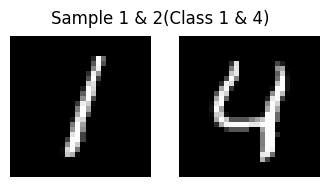

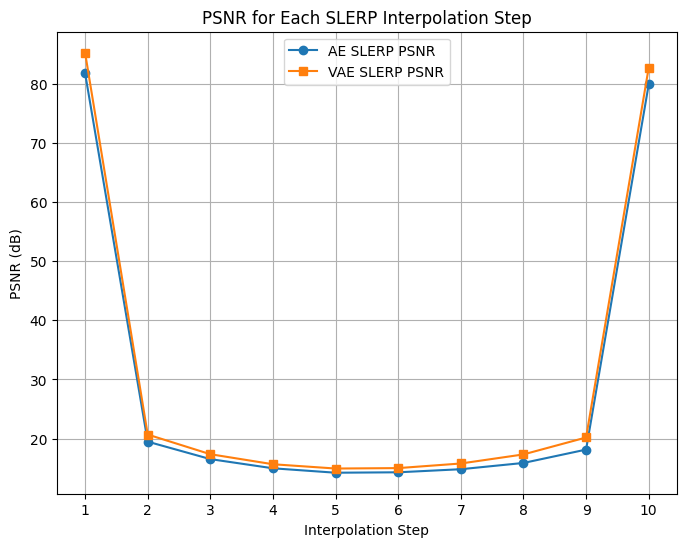

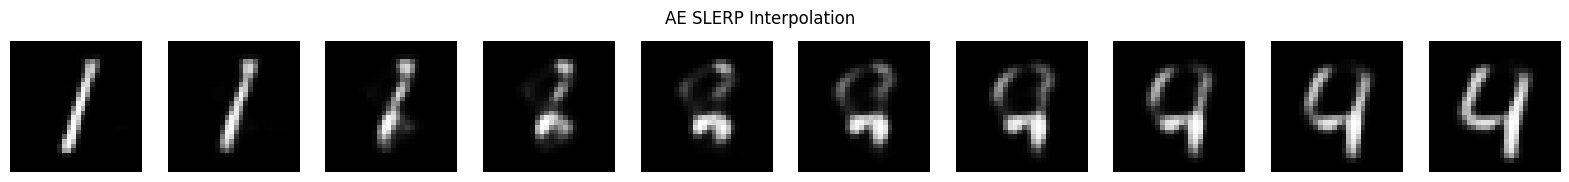

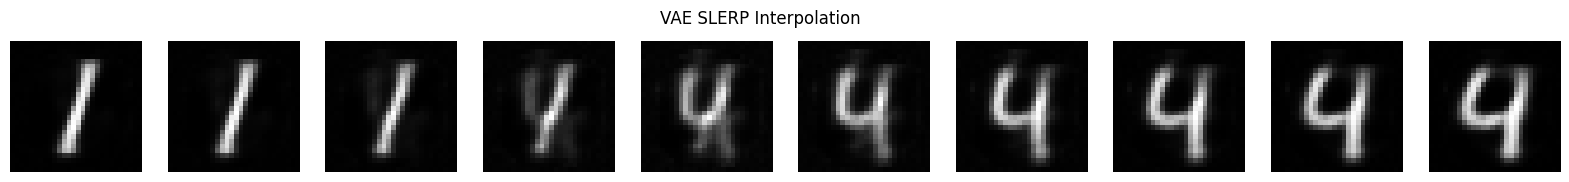

In [38]:
class1, class2 = 1, 4
interpolate(class1, class2)